In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import modal
from modal import Image

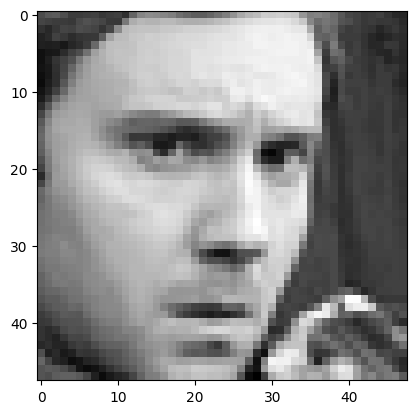

Emotion: angry


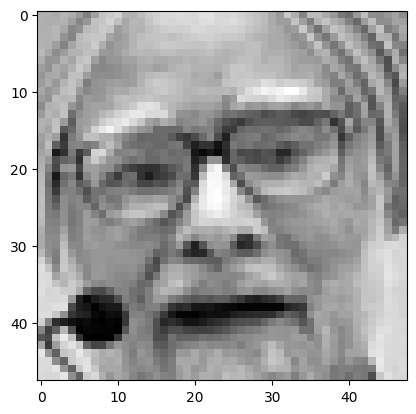

Emotion: angry


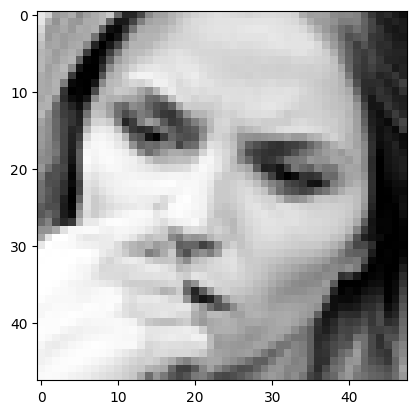

Emotion: fear


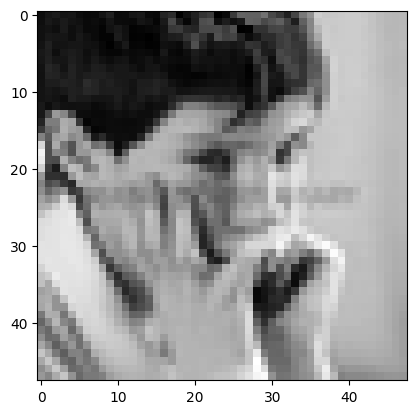

Emotion: sad


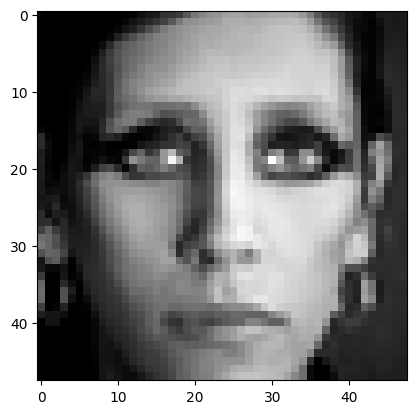

Emotion: neutral


In [3]:
RANDOM = 69

# load and preprocess data
data = pd.read_csv('dataset/fer2013.csv')
width, height = 48, 48
datapoints = data['pixels'].tolist()
faces = []
for pixel_sequence in datapoints:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
emotions = data['emotion'].values

emotion_labels = ["angry", "disgust", "fear", "happy", "sad", "suprise", "neutral"]
for i in range(5):
    plt.imshow(faces[i].squeeze(), cmap='gray')
    plt.show()

    print(f"Emotion: {emotion_labels[emotions[i]]}")

In [38]:
# config 
train_ratio = 0.8
eval_ratio  = 0.1
test_ratio  = 0.1

# First, split the data into training and remaining sets
x_train, x_rem, y_train, y_rem = train_test_split(faces, emotions, train_size=0.8, stratify=emotions, random_state=RANDOM)

# Then, split the remaining data into testing and evaluation sets
x_test, x_eval, y_test, y_eval = train_test_split(x_rem, y_rem, train_size=0.5, stratify=y_rem, random_state=RANDOM)

all_labels = np.unique(y_train)

# Get the subset of the data for each expert
expert_0_labels = [3, 6] # happy, neutral
expert_1_labels = [2, 5] # fear, suprise
expert_2_labels = [0, 1, 4] # angry, disgusted, sad

def mask(x, y, included_labels):
    masked_x = [x[y == label] for label in included_labels]
    masked_y = [y[y == label] for label in included_labels]

    return np.concatenate(masked_x), np.concatenate(masked_y)

def mask_and_oversample(x, y, included_labels):
    # Group the dataset up by class
    train_faces_by_class = [x[y == label] for label in included_labels]
    train_emotions_by_class = [y[y == label] for label in included_labels]

    train_max = max(len(face_class) for face_class in train_faces_by_class)

    # Oversample the minority classes
    oversampled_x = []
    oversampled_y = []

    def getResampleIndices(num_to_sample, class_len):
        samples = []
        sample_index = 0
        while num_to_sample > 0:
            if sample_index >= class_len:
                sample_index = 0
            samples.append(sample_index)
            sample_index += 1
            num_to_sample -= 1
    
        return samples

    for face_class, emotion_class in zip(train_faces_by_class, train_emotions_by_class):
        num_to_sample = train_max - face_class.shape[0]

        resample_map = getResampleIndices(num_to_sample, face_class.shape[0])
        resampled_inputs = face_class[resample_map]
        resampled_labels = emotion_class[resample_map]

        final_faces = np.concatenate([face_class, resampled_inputs])
        final_emotions = np.concatenate([emotion_class, resampled_labels])

        oversampled_x.append(final_faces)
        oversampled_y.append(final_emotions)

    # Put our oversampled dataset back together 
    x = np.concatenate(oversampled_x)
    y = np.concatenate(oversampled_y)

    return x, y

e0_x_train, e0_y_train = mask_and_oversample(x_train, y_train, expert_0_labels)
e0_x_eval, e0_y_eval = mask(x_eval, y_eval, expert_0_labels)

e1_x_train, e1_y_train = mask_and_oversample(x_train, y_train, expert_1_labels)
e1_x_eval, e1_y_eval = mask(x_eval, y_eval, expert_1_labels)

e2_x_train, e2_y_train = mask_and_oversample(x_train, y_train, expert_2_labels)
e2_x_eval, e2_y_eval = mask(x_eval, y_eval, expert_2_labels)

x_train, y_train = mask_and_oversample(x_train, y_train, all_labels)

# def transform_dataset_for_moe_gate(y_train):
#     bin_mapping = {
#         0: 2,
#         1: 2,
#         2: 1,
#         3: 0,
#         4: 2,
#         5: 1,
#         6: 0
#     }

#     y_train_reduced = np.vectorize(bin_mapping.get)(y_train)

#     return y_train_reduced

# gate_y_train = transform_dataset_for_moe_gate(y_train)
# gate_y_eval  = transform_dataset_for_moe_gate(y_eval)

# normalize and turn 2 tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

x_train = np.array([transform(x_train[i]) for i in range(x_train.shape[0])])
x_eval = np.array([transform(x_eval[i]) for i in range(x_eval.shape[0])])
x_test = np.array([transform(x_test[i]) for i in range(x_test.shape[0])])

e0_x_train = np.array([transform(e0_x_train[i]) for i in range(e0_x_train.shape[0])])
e0_x_eval  = np.array([transform(e0_x_eval[i]) for i in range(e0_x_eval.shape[0])])

e1_x_train = np.array([transform(e1_x_train[i]) for i in range(e1_x_train.shape[0])])
e1_x_eval  = np.array([transform(e1_x_eval[i]) for i in range(e1_x_eval.shape[0])])

e2_x_train = np.array([transform(e2_x_train[i]) for i in range(e2_x_train.shape[0])])
e2_x_eval  = np.array([transform(e2_x_eval[i]) for i in range(e2_x_eval.shape[0])])



In [39]:
# GPU acceleration
stub = modal.Stub(name="moe")

image = (
    Image.debian_slim(python_version="3.12.1")
    .pip_install(
        "torch==2.2.1",
        "torchvision==0.17.1",
    )
)

@stub.function(
    gpu="any",
    image=image,
)
def train(train_loader, eval_loader, model, criterion, optimizer, epochs=3, meta_data=None):
    print("Entered train function...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device.type}")

    model.to(device)

    def run_epoch():
        model.train()

        total_loss = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss

        return total_loss / len(train_loader)
        

    def calculate_accuracy(loader):
        model.eval()

        correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                correct += torch.sum(preds == labels)
                total_samples += inputs.size(0)

        return (correct, total_samples)
   
    if meta_data == None:
        meta_data = []
         
    for i in range(epochs):
        print("-"*25)

        epoch = len(meta_data)
        print(f"Epoch: {epoch}")

        eval_correct, eval_total = calculate_accuracy(eval_loader)
        train_correct, train_total = calculate_accuracy(train_loader)

        train_accuracy = train_correct.to('cpu') / train_total
        eval_accuracy = eval_correct.to('cpu') / eval_total

        print(f"Train: {train_correct}/{train_total} | {train_accuracy}")
        print(f"Eval: {eval_correct}/{eval_total} | {eval_accuracy}")

        loss = run_epoch()
        print(f"Loss: {loss}")

        meta_data.append({'epoch': epoch, 'train': float(train_accuracy), 'eval': float(eval_accuracy), 'loss': float(loss)})

        epoch += 1
    
    model.to('cpu')

    print(f"Saving model checkpoint at {len(meta_data)}th epoch")

    return model, meta_data

In [20]:
# # Prepare datasets and loaders
# train_dataset = torch.utils.data.TensorDataset(torch.tensor(e2_x_train), torch.tensor(e2_y_train))
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# eval_dataset = torch.utils.data.TensorDataset(torch.tensor(e2_x_eval), torch.tensor(e2_y_eval))
# eval_loader = DataLoader(eval_dataset, batch_size=len(eval_dataset), shuffle=False)

# # define the model
# model = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=7)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# # define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# if os.path.exists('e2_state_dict.pth') and os.path.exists('e2_meta_data.pkl'):
#     model.load_state_dict(torch.load("e2_state_dict.pth", map_location=torch.device('cpu')))

#     with open('e2_meta_data.pkl', 'rb') as file:
#         loaded_meta_data = pickle.load(file)

#         with stub.run():
#             model, meta_data = train.remote(train_loader, eval_loader, model, criterion, optimizer, 3, loaded_meta_data)

#             model.to('cpu')

#             torch.save(model.state_dict(), 'e2_state_dict.pth')
#             with open('e2_meta_data.pkl', 'wb') as file:
#                 pickle.dump(meta_data, file)
# else:
#     with stub.run():
#         model, meta_data = train.remote(train_loader, eval_loader, model, criterion, optimizer)

#         model.to('cpu')

#         torch.save(model.state_dict(), 'e2_state_dict.pth')

#         with open('e2_meta_data.pkl', 'wb') as file:
#             pickle.dump(meta_data, file)

✓ Initialized. View run at https://modal.com/imenkedir/apps/ap-XM1z8MxoRl0wkg3R2hGT03

✓ Created objects.
└── 🔨 Created train.

Entered train function...


Device: cuda


-------------------------
Epoch: 12


Train: 13115/14583 | 0.8993348479270935
Eval: 755/1158 | 0.6519861817359924


Loss: 0.24655863642692566


-------------------------


Epoch: 13


Train: 13230/14583 | 0.907220721244812


Eval: 764/1158 | 0.6597582101821899


Loss: 0.23104916512966156


-------------------------


Epoch: 14


Train: 13387/14583 | 0.9179866909980774


Eval: 763/1158 | 0.6588946580886841


Loss: 0.2181539535522461


Saving model checkpoint at 15th epoch


Stopping app - local entrypoint completed.


✓ App completed. View run at https://modal.com/imenkedir/apps/ap-XM1z8MxoRl0wkg3R2hGT03

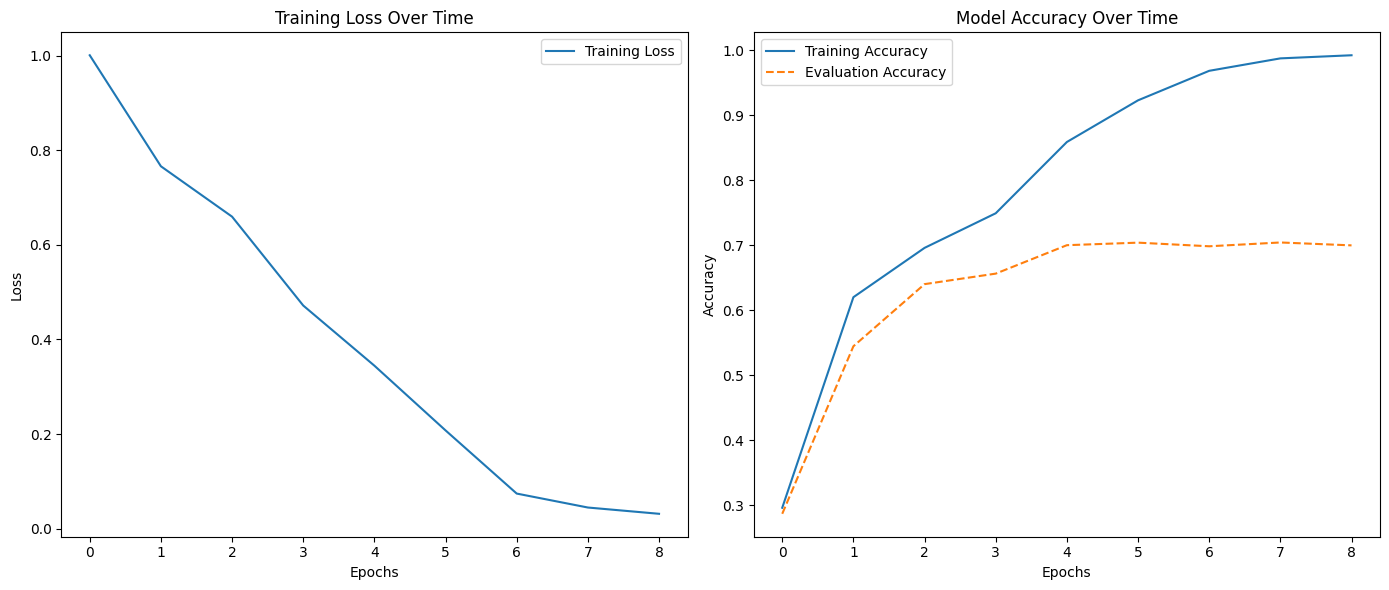

In [6]:
with open('gate_checkpoints/gate_meta_data.pkl', 'rb') as file:
    loaded_meta_data = pickle.load(file)

    # Assuming 'meta_data' is the list returned by your training function
    epochs = [entry['epoch'] for entry in loaded_meta_data]
    losses = [entry['loss'] for entry in loaded_meta_data]
    train_accuracies = [entry['train'] for entry in loaded_meta_data]
    eval_accuracies = [entry['eval'] for entry in loaded_meta_data]

    # Plotting the training loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    # Plotting the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, eval_accuracies, label='Evaluation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

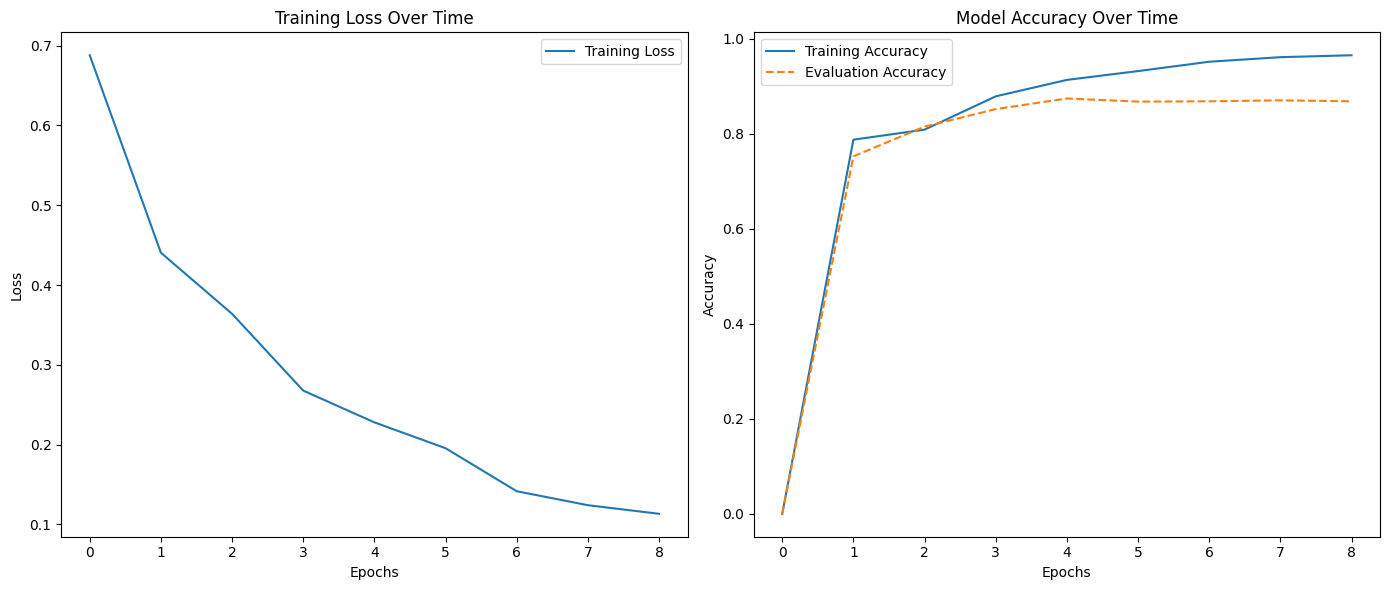

In [7]:
with open('e0_checkpoints/e0_meta_data.pkl', 'rb') as file:
    loaded_meta_data = pickle.load(file)

    # Assuming 'meta_data' is the list returned by your training function
    epochs = [entry['epoch'] for entry in loaded_meta_data]
    losses = [entry['loss'] for entry in loaded_meta_data]
    train_accuracies = [entry['train'] for entry in loaded_meta_data]
    eval_accuracies = [entry['eval'] for entry in loaded_meta_data]

    # Plotting the training loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    # Plotting the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, eval_accuracies, label='Evaluation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

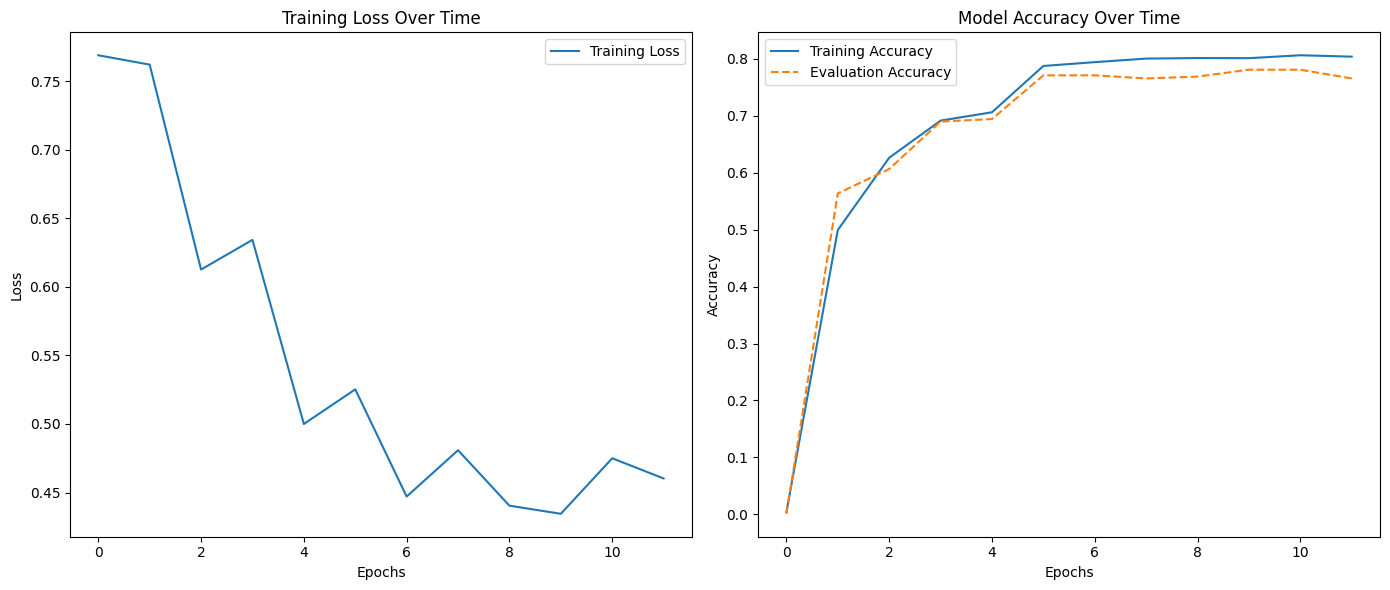

In [8]:
with open('e1_checkpoints/e1_meta_data.pkl', 'rb') as file:
    loaded_meta_data = pickle.load(file)

    # Assuming 'meta_data' is the list returned by your training function
    epochs = [entry['epoch'] for entry in loaded_meta_data]
    losses = [entry['loss'] for entry in loaded_meta_data]
    train_accuracies = [entry['train'] for entry in loaded_meta_data]
    eval_accuracies = [entry['eval'] for entry in loaded_meta_data]

    # Plotting the training loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    # Plotting the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, eval_accuracies, label='Evaluation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

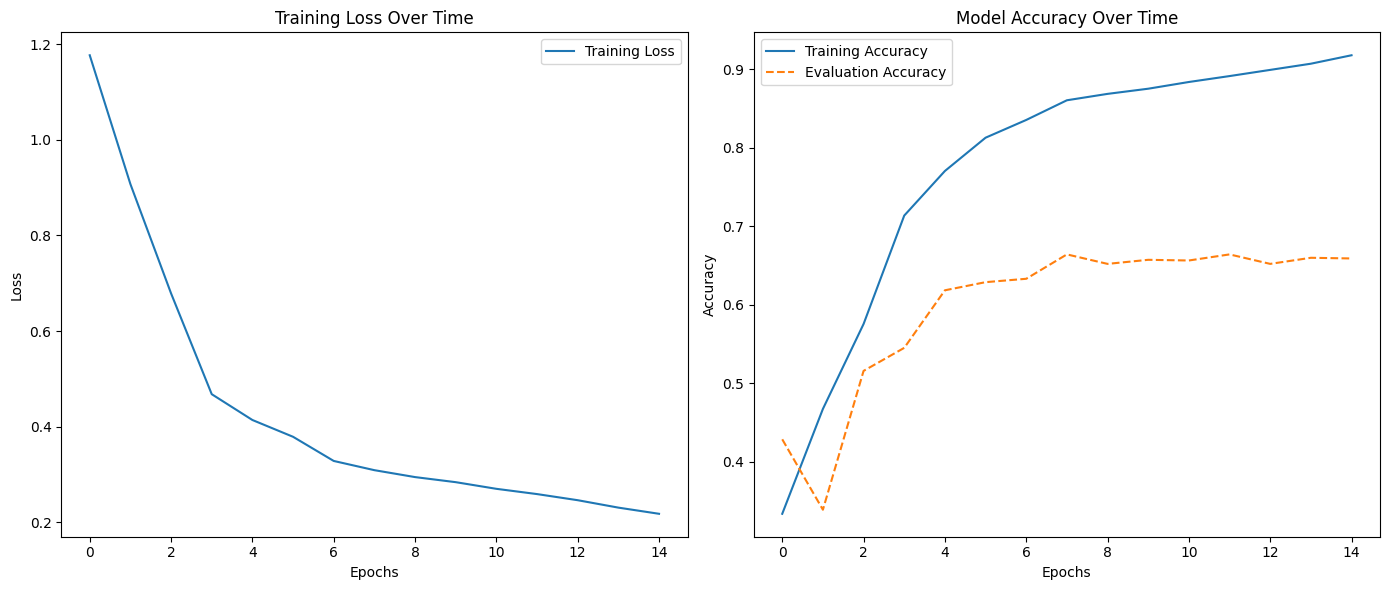

In [9]:
with open('e2_checkpoints/e2_meta_data.pkl', 'rb') as file:
    loaded_meta_data = pickle.load(file)

    # Assuming 'meta_data' is the list returned by your training function
    epochs = [entry['epoch'] for entry in loaded_meta_data]
    losses = [entry['loss'] for entry in loaded_meta_data]
    train_accuracies = [entry['train'] for entry in loaded_meta_data]
    eval_accuracies = [entry['eval'] for entry in loaded_meta_data]

    # Plotting the training loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    # Plotting the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, eval_accuracies, label='Evaluation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [43]:
@stub.function(
    gpu="any",
    image=image,
)
def run_moe(loader, gate, e0, e1, e2):
    print("Entered forward function")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    gate.to(device)
    e0.to(device)
    e1.to(device)
    e2.to(device)

    gate.eval()
    e0.eval()
    e1.eval()
    e2.eval()
    
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            gate_outputs = gate(inputs)

            e0_outputs   = e0(inputs)
            e1_outputs   = e1(inputs)
            e2_outputs   = e2(inputs)

            expert_weights = F.softmax(gate_outputs, dim=1)

            weighted_e0_outputs = expert_weights[:, 0:1] * e0_outputs
            weighted_e1_outputs = expert_weights[:, 1:2] * e1_outputs
            weighted_e2_outputs = expert_weights[:, 2:3] * e2_outputs

            aggergated_outputs = weighted_e0_outputs + weighted_e1_outputs + weighted_e2_outputs

            predictions = aggergated_outputs.argmax(dim=1) 

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())


    return true_labels, predicted_labels 

@stub.function(
    gpu="any",
    image=image,
)
def run_baseline(loader, model):
    print("Entered forward function")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    model.to(device)

    model.eval()
    
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            predictions = outputs.argmax(dim=1) 

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    return true_labels, predicted_labels

            



In [44]:
# Prepare datasets and loaders
eval_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test), torch.tensor(y_test))
eval_loader = DataLoader(eval_dataset, batch_size=len(eval_dataset), shuffle=False)

baseline = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=7)
baseline.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
baseline.load_state_dict(torch.load("baseline_checkpoints/model_state_dict_epoch_8.pth", map_location=torch.device('cpu')))

gate = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=3)
gate.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
gate.load_state_dict(torch.load("gate_checkpoints/gate_state_dict_epoch_8.pth", map_location=torch.device('cpu')))

e0 = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2],  num_classes=7)
e0.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
e0.load_state_dict(torch.load("e0_checkpoints/e0_state_dict_epoch_5.pth", map_location=torch.device('cpu')))

e1 = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2],  num_classes=7)
e1.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
e1.load_state_dict(torch.load("e1_checkpoints/e1_state_dict_epoch_5.pth", map_location=torch.device('cpu')))

e2 = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2],  num_classes=7)
e2.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
e2.load_state_dict(torch.load("e2_checkpoints/e2_state_dict_epoch_8.pth", map_location=torch.device('cpu')))


with stub.run():
    b_p, b_t = run_baseline.remote(eval_loader, baseline)
    m_p, m_t = run_moe.remote(eval_loader, gate, e0, e1, e2)


/Users/imenkedir/miniforge3/envs/EmotionRecML/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

✓ Initialized. View run at https://modal.com/imenkedir/apps/ap-ctgLGsC1rz0BWif4yuW5TY

✓ Created objects.
├── 🔨 Created train.
├── 🔨 Created run_moe.
└── 🔨 Created run_baseline.

Entered forward function


cuda


Entered forward function


cuda


Stopping app - local entrypoint completed.


✓ App completed. View run at https://modal.com/imenkedir/apps/ap-ctgLGsC1rz0BWif4yuW5TY

In [46]:
def calculate_class_accuracies(preds, labels):
    correct = {i: 0 for i in range(7)}
    total = {i: 0 for i in range(7)}

    for i in range(len(labels)):
        label = labels[i].item()
        pred = preds[i].item()

        if label == pred:
            correct[label] += 1
        total[label] += 1

    accuracies = {i: correct[i] / total[i] for i in range(7)}
    return accuracies

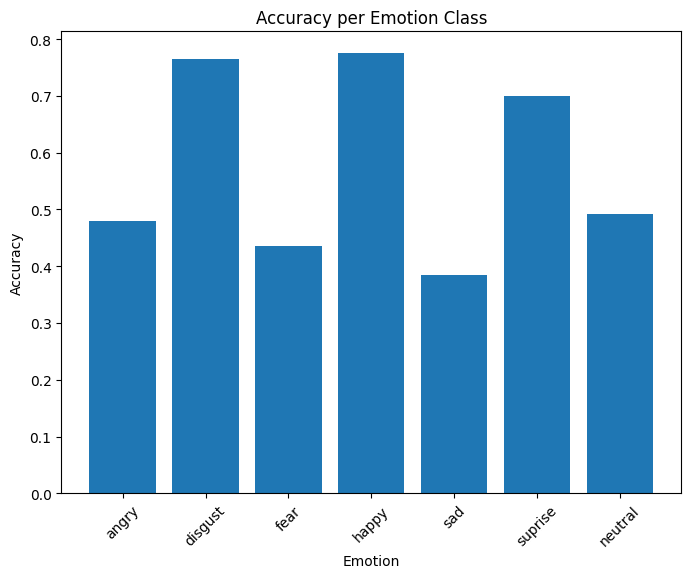

In [47]:
a = calculate_class_accuracies(b_p, b_t)

plt.figure(figsize=(8, 6))
plt.bar(emotion_labels, a.values())
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Accuracy per Emotion Class')
plt.xticks(rotation=45)
plt.show()

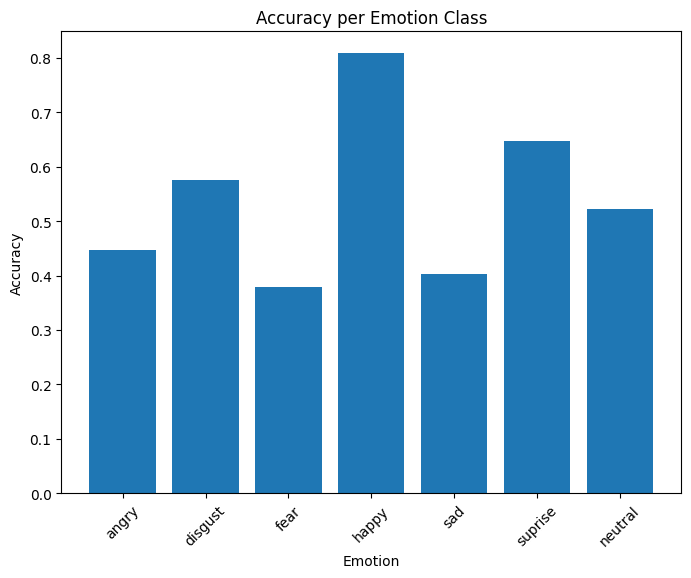

In [49]:
a = calculate_class_accuracies(m_p, m_t)

plt.figure(figsize=(8, 6))
plt.bar(emotion_labels, a.values())
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Accuracy per Emotion Class')
plt.xticks(rotation=45)
plt.show()